#Generating pseudo ladel using unet model

In [1]:
import os
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [2]:
# Directory paths
unlabeled_dir = r"C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\images\val" 
output_dir = r"C:\Users\arunm\thusharproj\test\psfinalmask1"  
val_set=r"C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\annotations\val"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Load the trained model architecture and weights
with open("model.json", "r") as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)
model.load_weights("final_modelcopy.h5")
print("Loaded model from disk")


Loaded model from disk


In [4]:
# Image size and batch size
img_size = (160, 160)  # Use the same size as used during training
batch_size = 16  # Adjust as needed

# Get paths to unlabeled images
unlabeled_img_paths = sorted([
    os.path.join(unlabeled_dir, fname)
    for fname in os.listdir(unlabeled_dir)
    if fname.endswith(".jpg")  # Adjust the extension if your images have a different format
])


In [5]:
# Predict and save the pseudo-labels
for i in range(0, len(unlabeled_img_paths), batch_size):
    batch_paths = unlabeled_img_paths[i:i + batch_size]
    batch_images = np.zeros((len(batch_paths),) + img_size + (3,), dtype="float32")

    for j, path in enumerate(batch_paths):
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize the image
        batch_images[j] = img_array

    # Predict segmentation masks for the batch
    predictions = model.predict(batch_images)

    for j, prediction in enumerate(predictions):
        # Convert prediction to binary mask
        mask = np.argmax(prediction, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        mask_img = array_to_img(mask * 255)  # Rescale to [0, 255]

        # Save the mask image
        output_path = os.path.join(output_dir, os.path.basename(batch_paths[j]).replace(".jpg", "_mask.png"))
        mask_img.save(output_path)

        print(f"Saved pseudo-label for {batch_paths[j]} as {output_path}")

1/1 [==============================] - 1s 940ms/step
Saved pseudo-label for C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\images\val\ISIC_0012255.jpg as C:\Users\arunm\thusharproj\test\psfinalmask1\ISIC_0012255_mask.png
Saved pseudo-label for C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\images\val\ISIC_0012346.jpg as C:\Users\arunm\thusharproj\test\psfinalmask1\ISIC_0012346_mask.png
Saved pseudo-label for C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\images\val\ISIC_0012576.jpg as C:\Users\arunm\thusharproj\test\psfinalmask1\ISIC_0012576_mask.png
Saved pseudo-label for C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\images\val\ISIC_0012585.jpg as C:\Users\arunm\thusharproj\test\psfinalmask1\ISIC_0012585_mask.png
Saved pseudo-label for C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\images\val\ISIC_0012623.jpg as C:\Users\arunm\thusharproj\test\psfinalmask1\ISIC_0012623_mask.png
Saved pseudo-label for C:\Users\arunm\thusharproj\test\2018LA_

In [9]:
import numpy as np
import os
import cv2

def calculate_metrics(ground_truth_dir, generated_masks_dir):
    ground_truth_files = sorted(os.listdir(ground_truth_dir))
    generated_masks_files = sorted(os.listdir(generated_masks_dir))
    
    assert len(ground_truth_files) == len(generated_masks_files), "Mismatch in number of ground truth and generated masks"
    
    jaccard_scores = []
    dice_scores = []
    pixel_accuracies = []
    sensitivities = []
    specificities = []
    
    for gt_file, gen_file in zip(ground_truth_files, generated_masks_files):
        # Read ground truth mask
        gt_mask = cv2.imread(os.path.join(ground_truth_dir, gt_file), cv2.IMREAD_GRAYSCALE)
        
        # Read generated mask
        gen_mask = cv2.imread(os.path.join(generated_masks_dir, gen_file), cv2.IMREAD_GRAYSCALE)
        
        # Resize generated mask to match the ground truth mask
        gen_mask_resized = cv2.resize(gen_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        # Binarize masks (threshold at 127)
        gt_mask = (gt_mask > 127).astype(np.uint8)
        gen_mask_resized = (gen_mask_resized > 127).astype(np.uint8)
        
        # Calculate confusion matrix components
        TP = np.sum((gt_mask == 1) & (gen_mask_resized == 1))  # True Positives
        TN = np.sum((gt_mask == 0) & (gen_mask_resized == 0))  # True Negatives
        FP = np.sum((gt_mask == 0) & (gen_mask_resized == 1))  # False Positives
        FN = np.sum((gt_mask == 1) & (gen_mask_resized == 0))  # False Negatives
        
        # Jaccard Index (Intersection over Union)
        jaccard = TP / (TP + FP + FN + 1e-10)
        jaccard_scores.append(jaccard)
        
        # Dice Score
        dice = (2 * TP) / (2 * TP + FP + FN + 1e-10)
        dice_scores.append(dice)
        
        # Pixel Accuracy
        pixel_accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-10)
        pixel_accuracies.append(pixel_accuracy)
        
        # Sensitivity (Recall)
        sensitivity = TP / (TP + FN + 1e-10)
        sensitivities.append(sensitivity)
        
        # Specificity
        specificity = TN / (TN + FP + 1e-10)
        specificities.append(specificity)
    
    # Average scores over all masks
    avg_jaccard = np.mean(jaccard_scores)
    avg_dice = np.mean(dice_scores)
    avg_pixel_accuracy = np.mean(pixel_accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print(f'Jaccard Score: {avg_jaccard}')
    print(f'Dice Score: {avg_dice}')
    print(f'Pixel accuracy: {avg_pixel_accuracy}')
    print(f'Sensitivity: {avg_sensitivity}')
    print(f'Specificity: {avg_specificity}')
    
    return {
        'Jaccard Score': avg_jaccard,
        'Dice Score': avg_dice,
        'Pixel accuracy': avg_pixel_accuracy,
        'Sensitivity': avg_sensitivity,
        'Specificity': avg_specificity
    }

# Example usage
ground_truth_dir = r"C:\Users\arunm\thusharproj\test\2018LA_Seg_Training Set\annotations\val"
generated_masks_dir = r"C:\Users\arunm\thusharproj\test\psfinalmask"

calculate_metrics(ground_truth_dir, generated_masks_dir)


Jaccard Score: 0.740187414905259
Dice Score: 0.8227718337751688
Pixel accuracy: 0.9009549930570777
Sensitivity: 0.844800900836812
Specificity: 0.9367698526128787


{'Jaccard Score': 0.740187414905259,
 'Dice Score': 0.8227718337751688,
 'Pixel accuracy': 0.9009549930570777,
 'Sensitivity': 0.844800900836812,
 'Specificity': 0.9367698526128787}

In [2]:
#Comparision between Model A, Model B and Model C

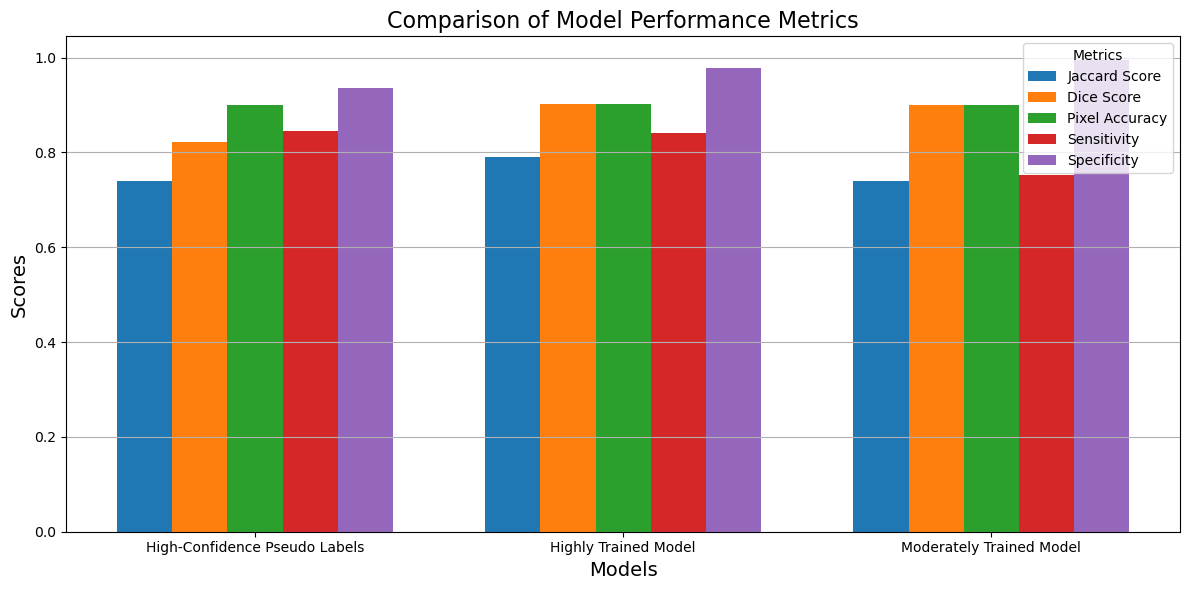

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Scores for different models
models = ['High-Confidence Pseudo Labels', 'Highly Trained Model', 'Moderately Trained Model']
scores = {
    'Jaccard Score': [0.794860062912648, 0.7907477657010648, 0.7398150258661742],
    'Dice Score': [0.8719920642134068, 0.9024471028645834, 0.8998339843750001],
    'Pixel Accuracy': [0.930441086192999, 0.9024471028645834, 0.8998339843750001],
    'Sensitivity': [0.8758150583081326, 0.8407353279952084, 0.7524865243027754],
    'Specificity': [0.9676883085816259, 0.9773799083341359, 0.9952713535005344]
}

# Bar width
bar_width = 0.15
x = np.arange(len(models))

# Create subplots for each score
fig, ax = plt.subplots(figsize=(12, 6))

for i, (metric, values) in enumerate(scores.items()):
    ax.bar(x + i * bar_width, values, width=bar_width, label=metric)

# Add labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Comparison of Model Performance Metrics', fontsize=16)
ax.set_xticks(x + bar_width * (len(scores) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(title='Metrics')

# Show grid
ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


In [4]:
#Metric wise comparision

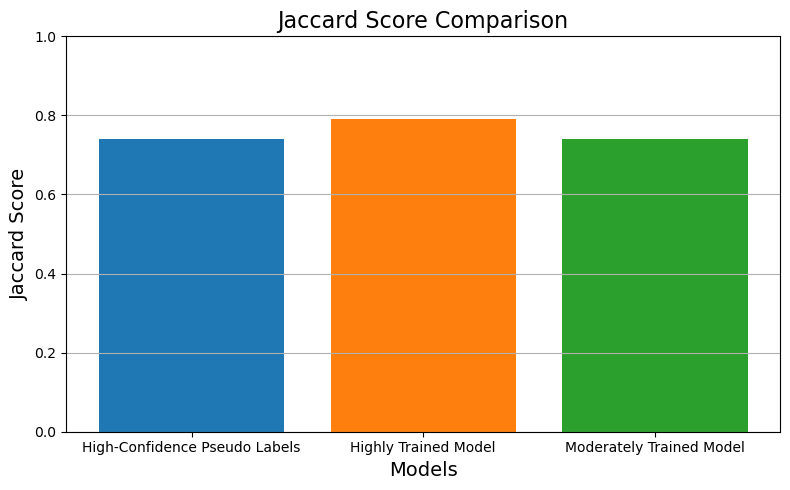

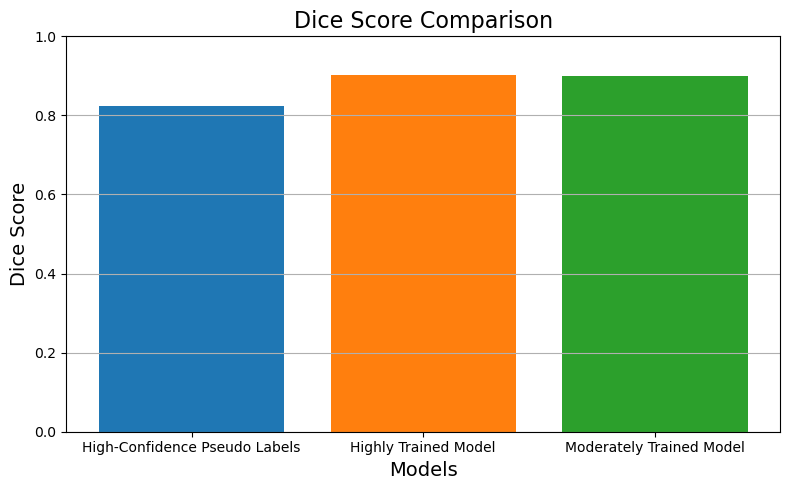

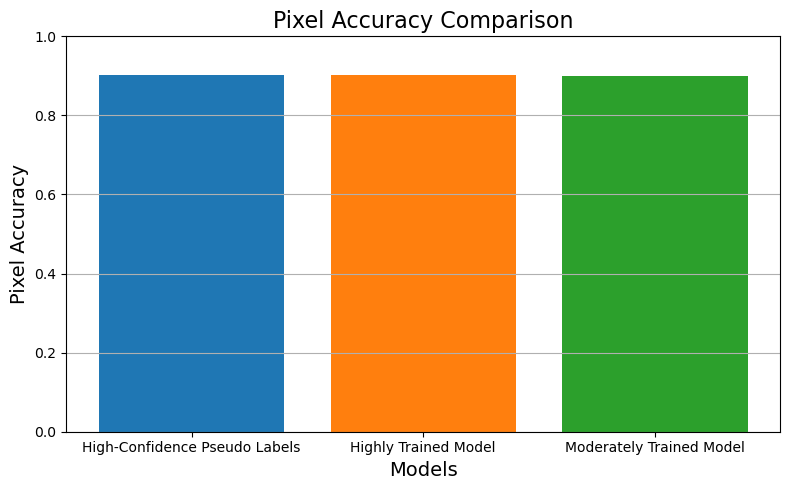

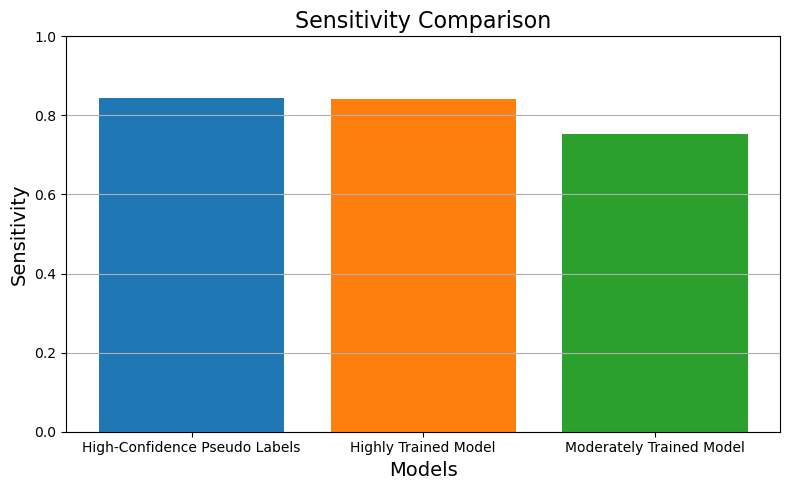

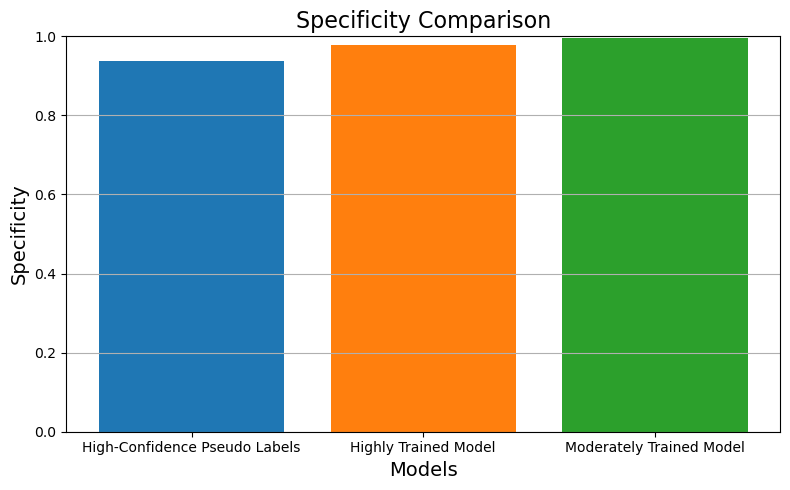

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Scores for different models
models = ['High-Confidence Pseudo Labels', 'Highly Trained Model', 'Moderately Trained Model']
scores = {
    'Jaccard Score': [0.794860062912648, 0.7907477657010648, 0.7398150258661742],
    'Dice Score': [0.8719920642134068, 0.9024471028645834, 0.8998339843750001],
    'Pixel Accuracy': [0.930441086192999, 0.9024471028645834, 0.8998339843750001],
    'Sensitivity': [0.8758150583081326, 0.8407353279952084, 0.7524865243027754],
    'Specificity': [0.9676883085816259, 0.9773799083341359, 0.9952713535005344]
}

# Create a figure for each metric
for metric, values in scores.items():
    plt.figure(figsize=(8, 5))
    plt.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    
    # Add labels and title
    plt.xlabel('Models', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.title(f'{metric} Comparison', fontsize=16)
    plt.ylim(0, 1)  # Set y-axis limits for better visualization
    plt.grid(axis='y')
    
    # Display the plot
    plt.tight_layout()
    plt.show()


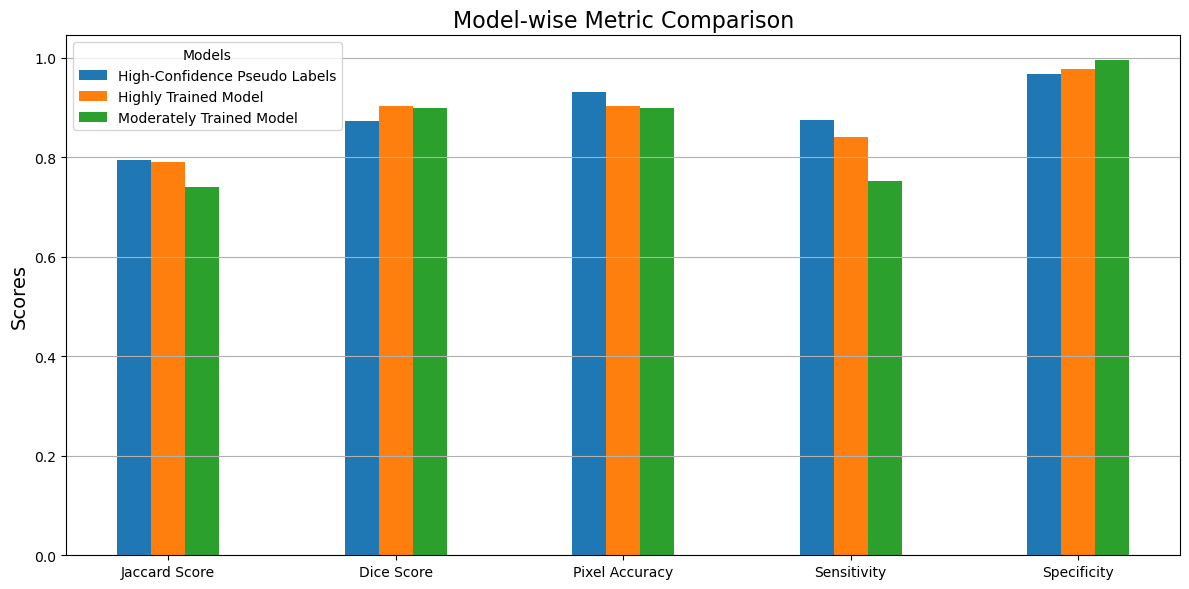

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Scores for different models
models = ['High-Confidence Pseudo Labels', 'Highly Trained Model', 'Moderately Trained Model']
scores = {
    'Jaccard Score': [0.794860062912648, 0.7907477657010648, 0.7398150258661742],
    'Dice Score': [0.8719920642134068, 0.9024471028645834, 0.8998339843750001],
    'Pixel Accuracy': [0.930441086192999, 0.9024471028645834, 0.8998339843750001],
    'Sensitivity': [0.8758150583081326, 0.8407353279952084, 0.7524865243027754],
    'Specificity': [0.9676883085816259, 0.9773799083341359, 0.9952713535005344]
}

# Prepare data for plotting
metrics = list(scores.keys())
values = np.array(list(scores.values()))

# Bar width and position
bar_width = 0.15
x = np.arange(len(metrics))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each model
for i, model in enumerate(models):
    ax.bar(x + i * bar_width, values[:, i], width=bar_width, label=model)

# Add labels and title
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Model-wise Metric Comparison', fontsize=16)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(metrics)
ax.legend(title='Models')

# Show grid
ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


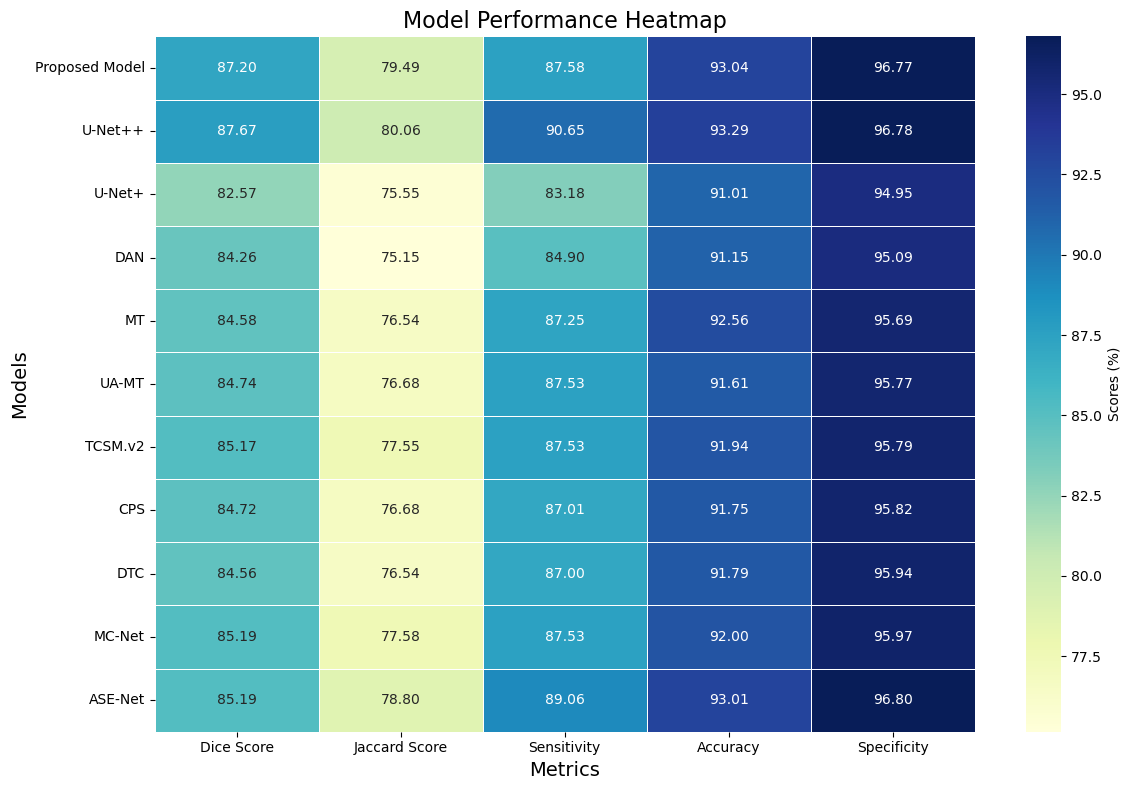

In [18]:
#Comparing all the previous models with the proposed model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for models and metrics
models = ['Proposed Model', 'U-Net++', 'U-Net+', 'DAN', 'MT', 'UA-MT', 'TCSM.v2', 'CPS', 'DTC', 'MC-Net', 'ASE-Net']
metrics = ['Dice Score', 'Jaccard Score', 'Sensitivity', 'Accuracy', 'Specificity']

# Values for each model and metric
values = [
    [0.8719920642134068, 0.794860062912648, 0.8758150583081326, 0.930441086192999, 0.9676883085816259],  # High-Confidence Pseudo Labels
    [0.8767, 0.8006, 0.9065, 0.9329, 0.9678],  # U-Net++
    [0.8257, 0.7555, 0.8318, 0.9101, 0.9495],  # U-Net+
    [0.8426, 0.7515, 0.8490, 0.9115, 0.9509],  # DAN
    [0.8458, 0.7654, 0.8725, 0.9256, 0.9569],  # MT
    [0.8474, 0.7668, 0.8753, 0.9161, 0.9577],  # UA-MT
    [0.8517, 0.7755, 0.8753, 0.9194, 0.9579],  # TCSM.v2
    [0.8472, 0.7668, 0.8701, 0.9175, 0.9582],  # CPS
    [0.8456, 0.7654, 0.8700, 0.9179, 0.9594],  # DTC
    [0.8519, 0.7758, 0.8753, 0.9200, 0.9597],  # MC-Net
    [0.8519, 0.7880, 0.8906, 0.9301, 0.9680]   # ASE-Net
]

# Create a DataFrame for better visualization
df = pd.DataFrame(values, columns=metrics, index=models) * 100  # Convert to percentage

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Scores (%)'}, linewidths=.5)

# Add labels and title
plt.title('Model Performance Heatmap', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Models', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
from prettytable import PrettyTable

# Define your data
data = {
    "Method": ["U-Net++", "U-Net+", "DAN", "MT", "UA-MT", "TCSMv2", "CPS", "DTC", "MC-Net", "ASE-Net"],
    "Supervised/Semi-supervised": ["2594/0", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335"],
    "Dice Score (DI)": [87.67, 82.57, 84.26, 84.58, 84.74, 85.17, 84.72, 85.14, 85.19, 85.19],
    "Jaccard Score (JA)": [80.06, 75.55, 76.54, 76.54, 76.68, 77.55, 76.68, 77.58, 77.58, 89.06],
    "Sensitivity (SE)": [90.65, 83.18, 84.90, 87.25, 87.53, 87.53, 87.01, 87.53, 87.53, 89.06],
    "Accuracy (AC)": [93.29, 91.01, 91.15, 92.56, 91.61, 91.94, 91.09, 91.94, 93.01, 93.01],
    "Specificity (SP)": [96.78, 94.95, 95.09, 96.01, 95.77, 95.79, 95.82, 95.82, 96.80, 96.80]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Add a new column to check if the method is supervised or semi-supervised
df['Supervision'] = df['Supervised/Semi-supervised'].apply(lambda x: 'Supervised' if x.split('/')[1] == '0' else 'Semi-supervised')

# Initialize the table
table = PrettyTable()

# Add columns to the table
table.field_names = ["Method", "Supervision", "Dice Score (DI)", "Jaccard Score (JA)", "Sensitivity (SE)", "Accuracy (AC)", "Specificity (SP)"]

# Loop through DataFrame and add rows to PrettyTable
for i, row in df.iterrows():
    table.add_row([row['Method'], row['Supervision'], row['Dice Score (DI)'], row['Jaccard Score (JA)'], row['Sensitivity (SE)'], row['Accuracy (AC)'], row['Specificity (SP)']])

# Print the table
print(table)


+---------+-----------------+-----------------+--------------------+------------------+---------------+------------------+
|  Method |   Supervision   | Dice Score (DI) | Jaccard Score (JA) | Sensitivity (SE) | Accuracy (AC) | Specificity (SP) |
+---------+-----------------+-----------------+--------------------+------------------+---------------+------------------+
| U-Net++ |    Supervised   |      87.67      |       80.06        |      90.65       |     93.29     |      96.78       |
|  U-Net+ | Semi-supervised |      82.57      |       75.55        |      83.18       |     91.01     |      94.95       |
|   DAN   | Semi-supervised |      84.26      |       76.54        |       84.9       |     91.15     |      95.09       |
|    MT   | Semi-supervised |      84.58      |       76.54        |      87.25       |     92.56     |      96.01       |
|  UA-MT  | Semi-supervised |      84.74      |       76.68        |      87.53       |     91.61     |      95.77       |
|  TCSMv2 | Semi

In [24]:
pip install PrettyTable

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


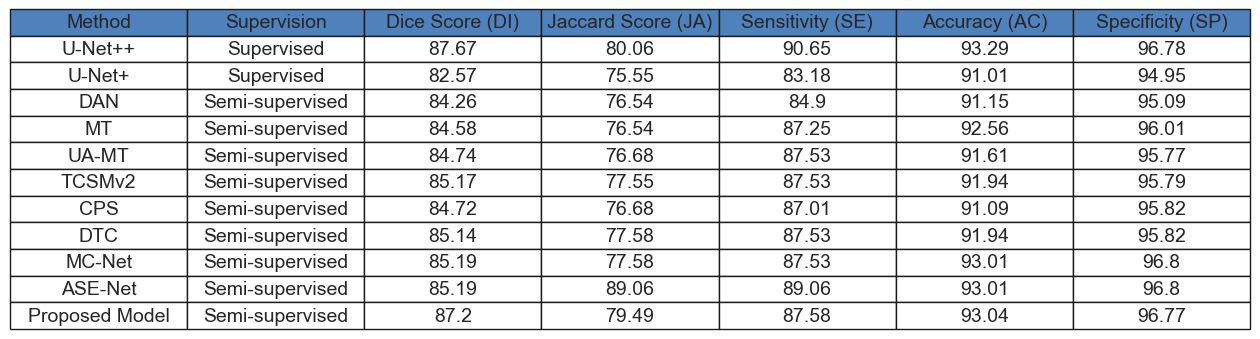

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define your data
data = {
    "Method": ["U-Net++", "U-Net+", "DAN", "MT", "UA-MT", "TCSMv2", "CPS", "DTC", "MC-Net", "ASE-Net", "Proposed Model"],
    "Supervised/Semi-supervised": ["2594/0", "259/0", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335", "259/2335"],
    "Dice Score (DI)": [87.67, 82.57, 84.26, 84.58, 84.74, 85.17, 84.72, 85.14, 85.19, 85.19,87.20],
    "Jaccard Score (JA)": [80.06, 75.55, 76.54, 76.54, 76.68, 77.55, 76.68, 77.58, 77.58, 89.06,79.49],
    "Sensitivity (SE)": [90.65, 83.18, 84.90, 87.25, 87.53, 87.53, 87.01, 87.53, 87.53, 89.06,87.58],
    "Accuracy (AC)": [93.29, 91.01, 91.15, 92.56, 91.61, 91.94, 91.09, 91.94, 93.01, 93.01,93.04],
    "Specificity (SP)": [96.78, 94.95, 95.09, 96.01, 95.77, 95.79, 95.82, 95.82, 96.80, 96.80,96.77]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Add a new column to check if the method is supervised or semi-supervised
df['Supervision'] = df['Supervised/Semi-supervised'].apply(lambda x: 'Supervised' if x.split('/')[1] == '0' else 'Semi-supervised')

# Drop the 'Supervised/Semi-supervised' column since it's no longer needed
df = df.drop(columns=['Supervised/Semi-supervised'])

# Reorder the columns to make it more readable
df = df[['Method', 'Supervision', 'Dice Score (DI)', 'Jaccard Score (JA)', 'Sensitivity (SE)', 'Accuracy (AC)', 'Specificity (SP)']]

# Plotting the table without background or grid
plt.figure(figsize=(10, 4))  # Adjust the size as needed

# Remove axis for cleaner table
ax = plt.gca()
ax.axis('off')

# Create the table using pandas' built-in styling features with no background noise
tbl = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=["#4f81bd"]*len(df.columns))

# Set table font size and scaling for better visuals
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(1.6, 1.6)

# Save the table as an image
plt.savefig('model_comparison_clean_table.png', bbox_inches='tight', dpi=300)
plt.show()
